### 리스크 관리 기법

때리기 전에 막는 법 부터 배워봅시다!

- 분산투자
- 채권 혼합
- 리밸런싱
- 장세에 따른 투자 비중 조절
- 자금관리
- 승률과 손익비
- 시스템 손절

In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet=None):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
        
#     # 자산별 비중이 반영된 개별자산 누적 수익률
#     weightedCumulativeReturn = weight * cumulativeReturn
#     # 자산흐름 정규화: 시기별 각 자산 보유 비율
#     normalizedAssetFlow = weightedCumulativeReturn.divide(weightedCumulativeReturn.sum(axis=1), axis=0) # 각 행의 합으로 각 행을 나누기
#     # 자산별 비중이 반영된 개별자산 일별 수익률
#     weightedDayReturn = normalizedAssetFlow * dayReturn.shift(-1).fillna(0)
#     # 포트폴리오 일별 수익률 = 자산별 비중이 반영된 개별자산 일별 수익률의 합
#     portfolioDayReturn = weightedDayReturn.sum(axis=1).shift(1).fillna(1)
#     # 포트폴리오 누적 수익률
#     portfolioCumulativeReturn = portfolioDayReturn.cumprod()
# #     portfolioCumulativeReturn = weightedCumulativeReturn.sum(axis=1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"cagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    
    # 만약, weightDf에 모든 종목이 0으로 잡히는 구간이 있다면
    noWeight = weightDf.sum(axis=1) == 0
    if not weightDf.loc[noWeight].empty :
        # weightDf에 모든 종목이 0인 구간에서는 cash 컬럼을 추가하여 1로 설정한다.
        weightDf['cash'] = np.where(noWeight, 1, 0)
        # 첫 투자 비중은 현금을 제외한 동일비중
        firstWeight = [1/(len(weightDf.columns)-1)] * len(weightDf.columns)
        firstWeight[-1] = 0
        weightDf.iloc[0] =  firstWeight
        # closeDataSet에 cash컬럼을 추가하여 1로 설정한다.
        closeDataSet['cash'] = 1
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getAvgMomentum(closeDataSet, n=12):
    """
    평균 모멘텀 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 평균 모멘텀 df
    """
    n = 12
    avgMomentum = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1~n개월 모멘텀 합 계산
    for i in range(1, n+1): 
        avgMomentum = dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) + avgMomentum
        
    avgMomentum = pd.DataFrame(avgMomentum) # dataframe으로 변환
    avgMomentum = (avgMomentum / 12).fillna(0) # 평균화
    return avgMomentum

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=dataSetOnRebalancingDate.index, columns=dataSetOnRebalancingDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / 12 # 평균화
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0) # 모멘텀 스코어에 따른 weight 계산
    return weight, avgMomentumScore

### 손실제한 시스템

In [26]:
# 데이터 로드
kodex200 = getCloseData("069500", "2002") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2002") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
# closeDataSet = pd.merge(kodex200, kodex10Bond, left_index= True , right_index= True)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
# closeDataSet['kodex10Bond'] = 1
closeDataSet.dropna(inplace=True)
rebalancingDate = getRebalancingDate(closeDataSet)
closeDataSet = closeDataSet.loc[rebalancingDate[0]:]
closeDataSet

,kodex200,kodex10Bond
Date,,
2012-01-31,21792,50180.0
2012-02-01,21819,50230.0
2012-02-02,22064,50180.0
2012-02-03,21952,50190.0
2012-02-06,21984,50120.0
...,...,...
2022-06-15,32285,61265.0
2022-06-16,32265,61355.0
2022-06-17,32025,61255.0


In [49]:
# 종가 데이터셋
closeDataSet
# 비중
weight, avgMomentumScore = getWeightByAvgMomentumScore(closeDataSet)
portfolioDayReturn, portfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet, weightDf=weight)

In [30]:
portfolioCumulativeReturn

Date
2012-01-31    1.000000
2012-02-01    1.001118
2012-02-02    1.006241
2012-02-03    1.003771
2012-02-06    1.003807
2012-02-07    1.004036
2012-02-08    1.009043
2012-02-09    1.011943
2012-02-10    1.005832
2012-02-13    1.008378
2012-02-14    1.008318
2012-02-15    1.014612
2012-02-16    1.008295
2012-02-17    1.014627
2012-02-20    1.015574
2012-02-21    1.016241
2012-02-22    1.015742
2012-02-23    1.012080
2012-02-24    1.014237
2012-02-27    1.008297
2012-02-28    1.012542
2012-02-29    1.018382
2012-03-02    1.019643
2012-03-05    1.010182
2012-03-06    1.001261
2012-03-07    0.993107
2012-03-08    1.004325
2012-03-09    1.013291
2012-03-12    1.007389
2012-03-13    1.019102
2012-03-14    1.030456
2012-03-15    1.030276
2012-03-16    1.026356
2012-03-19    1.031087
2012-03-20    1.027798
2012-03-21    1.021851
2012-03-22    1.022526
2012-03-23    1.021310
2012-03-26    1.020364
2012-03-27    1.031492
2012-03-28    1.029194
2012-03-29    1.019102
2012-03-30    1.016625
2012-0

In [5]:
# 주식만 == 시장수익률
stockDayReturn = getDayReturn(kodex200.loc[rebalancingDate[0]:])
stockCumReturn = getCumulativeReturn(kodex200.loc[rebalancingDate[0]:])

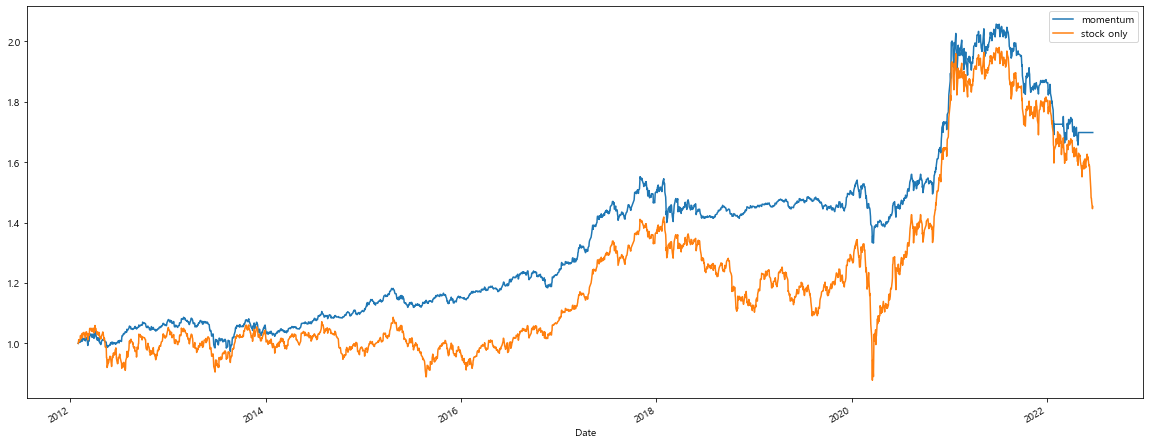

In [6]:
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(20,8))
portfolioCumulativeReturn.plot(label="momentum")
stockCumReturn.plot(label="stock only")
plt.legend()
plt.show()

In [29]:
pd.set_option("display.max_rows", None)

In [7]:
# 위 수익곡선에 이동평균을 확인해보자.
ma = portfolioCumulativeReturn.rolling(window=120, min_periods=1).mean()
ma

Date
2012-01-31    1.000000
2012-02-01    1.000559
2012-02-02    1.002453
2012-02-03    1.002782
2012-02-06    1.002987
                ...   
2022-06-15    1.737905
2022-06-16    1.736467
2022-06-17    1.735085
2022-06-20    1.733661
2022-06-21    1.732243
Length: 2558, dtype: float64

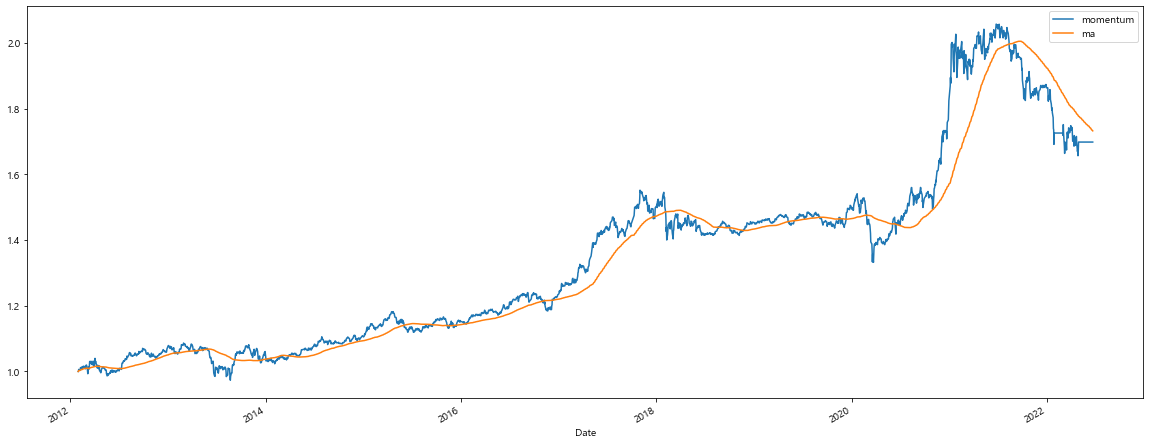

In [8]:
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(20,8))
portfolioCumulativeReturn.plot(label="momentum")
ma.plot(label="ma")
plt.legend()
plt.show()

### 손실제한 시스템 규칙

12개월 평균 몸멘텀 스코어 + 120일 수익곡선 이동평균 위에 있을 때만 투자 실행,,

In [9]:
# 평균 모멘텀 스코어 전략의 누적수익률이 이동평균보다 큰 구간. 즉, 투자가 실행되는 구간
status = portfolioCumulativeReturn > ma
status.value_counts()

True     1705
False     853
dtype: int64

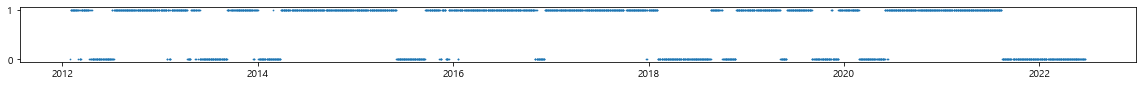

In [10]:
# 투자 실행구간 시각화
plt.figure(figsize=(20,1))
plt.scatter(x=status.index, y=status, s=0.5)

In [11]:
status

Date
2012-01-31    False
2012-02-01     True
2012-02-02     True
2012-02-03     True
2012-02-06     True
              ...  
2022-06-15    False
2022-06-16    False
2022-06-17    False
2022-06-20    False
2022-06-21    False
Length: 2558, dtype: bool



`오늘 일간 수익률 = 오늘 종가 / 전날 종가`  
단, 전날 매물을 보유하고 있을 때 계산 할 수 있다.

**규칙**  
* 앞에 F가 있거나 맨 앞의 T는 일간 수익률이 1이다.
* 앞에 T가 있는 F는 일간 수익률이 그대로다.
* 앞에 F가 있거나 맨 앞의 F는 일간 수익률이 1이다.

**결론**
* 앞에 F가 있는 T는 일간 수익률을 1로 바꾼다.
* 앞에 F가 있는 F는 일간 수익률을 1로 바꾼다.

In [12]:
# 기존 포트폴리오의 일간 수익률과 status를 합친 데이터프레임 생성
stopLossDayReturn = pd.concat([portfolioDayReturn, status], axis=1)
stopLossDayReturn.columns=['dayReturn', 'status']
# 이전 status값을 확인할 수 있는 컬럼 생성
stopLossDayReturn['previousStatus'] = stopLossDayReturn['status'].shift(1)
stopLossDayReturn

,dayReturn,status,previousStatus
Date,,,
2012-01-31,1.000000,False,NaN
2012-02-01,1.001118,True,False
2012-02-02,1.005117,True,True
2012-02-03,0.997545,True,True
2012-02-06,1.000037,True,True
...,...,...,...
2022-06-15,1.000000,False,False
2022-06-16,1.000000,False,False
2022-06-17,1.000000,False,False


In [13]:
# condition: 앞에 F가 있는 T 행
condition = (stopLossDayReturn['status'] == True) & (stopLossDayReturn['previousStatus'] == False)
# condition2: 앞에 F가 있는 F 행
condition2 = (stopLossDayReturn['status'] == False) & (stopLossDayReturn['previousStatus'] == False)

In [14]:
# 위 조건에 부합하는 행의 일간수익률을 1로 바꾼다.
stopLossDayReturn['dayReturn'].loc[condition | condition2] = 1

C:\Users\정지운\AppData\Local\Temp\ipykernel_2896\3634278188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stopLossDayReturn['dayReturn'].loc[condition | condition2] = 1


In [15]:
stopLossDayReturn

,dayReturn,status,previousStatus
Date,,,
2012-01-31,1.000000,False,NaN
2012-02-01,1.000000,True,False
2012-02-02,1.005117,True,True
2012-02-03,0.997545,True,True
2012-02-06,1.000037,True,True
...,...,...,...
2022-06-15,1.000000,False,False
2022-06-16,1.000000,False,False
2022-06-17,1.000000,False,False


In [16]:
dayReturn = stopLossDayReturn['dayReturn']
cumulativeReturn = dayReturn.cumprod()

In [17]:
getEvaluation(cumulativeReturn)

cagr: 1.0566751469550195
mdd: 6.815715538989951


(1.0566751469550195,
 Date
 2012-01-31    0.000000
 2012-02-01    0.000000
 2012-02-02    0.000000
 2012-02-03    0.245479
 2012-02-06    0.241829
                 ...   
 2022-06-15    3.582128
 2022-06-16    3.582128
 2022-06-17    3.582128
 2022-06-20    3.582128
 2022-06-21    3.582128
 Name: dayReturn, Length: 2558, dtype: float64,
 6.815715538989951)

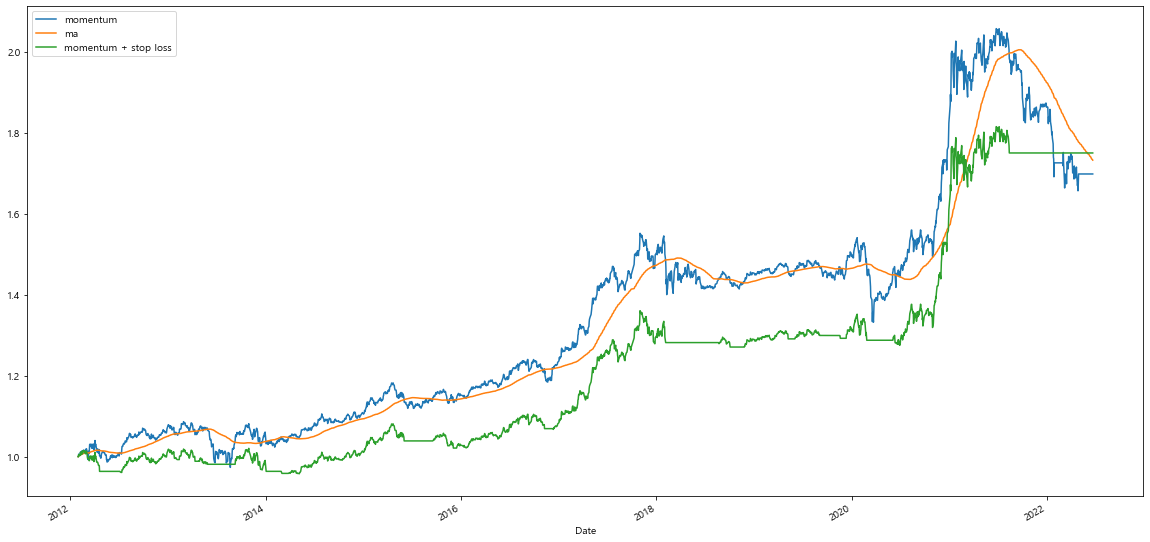

In [18]:
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(20,10))
portfolioCumulativeReturn.plot(label="momentum")
ma.plot(label="ma")
cumulativeReturn.plot(label="momentum + stop loss")
plt.legend()
plt.show()

### 수익곡선 모멘텀

In [53]:
# 평모스 리밸런싱 포트폴리오의 누적수익률

cumReturn = pd.DataFrame(portfolioCumulativeReturn, columns=["cumReturn"])
cumReturn

,cumReturn
Date,
2012-01-31,1.000000
2012-02-01,1.001118
2012-02-02,1.006241
2012-02-03,1.003771
2012-02-06,1.003807
2012-02-07,1.004036
2012-02-08,1.009043
2012-02-09,1.011943
2012-02-10,1.005832


In [54]:
# 평모스 리밸런싱 누적수익률의 평균모멘텀스코어
_, avgMomentumScore = getWeightByAvgMomentumScore(cumReturn, n= 6)
avgMomentumScore['cash'] = 1 - avgMomentumScore['cumReturn']
avgMomentumScore

,cumReturn,cash
Date,,
2012-01-31,0.000000,1.000000
2012-02-29,0.083333,0.916667
2012-03-30,0.083333,0.916667
2012-04-30,0.083333,0.916667
2012-05-31,0.083333,0.916667
2012-06-29,0.166667,0.833333
2012-07-31,0.500000,0.500000
2012-08-31,0.500000,0.500000
2012-09-28,0.500000,0.500000


In [55]:
# 평모스 리밸 누적수익률에 현금 종목 추가. 항상 누적수익률 1
cumReturn['cash'] = 1
cumReturn

,cumReturn,cash
Date,,
2012-01-31,1.000000,1
2012-02-01,1.001118,1
2012-02-02,1.006241,1
2012-02-03,1.003771,1
2012-02-06,1.003807,1
2012-02-07,1.004036,1
2012-02-08,1.009043,1
2012-02-09,1.011943,1
2012-02-10,1.005832,1


<AxesSubplot:xlabel='Date'>

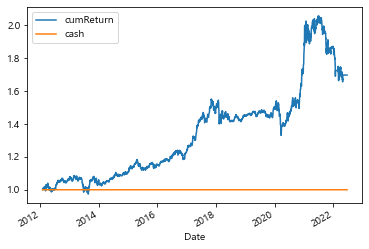

In [35]:
cumReturn.plot()

In [ ]:
# 그러면, 전략 자체를 하나의 종목으로 보고,
# 누적수익률과 자산 비율이 있으니
# 이 전체 포트폴리오의 누적수익률을 구할 수 있겠군

<AxesSubplot:xlabel='Date'>

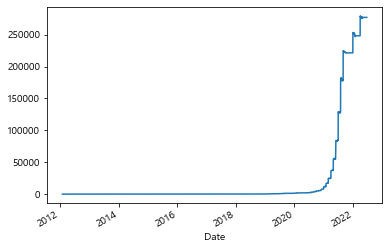

In [39]:

start = avgMomentumScore.index[0]
totalAsset = 1 # 초기자본
df = pd.DataFrame()

for end in avgMomentumScore.index[1:]:
    weight = avgMomentumScore.loc[start] # 당월 weight
    unitCumReturn = cumReturn.loc[start:end] # 당월 누적 수익률
    weightedUnitCumReturn = weight * unitCumReturn  # 당월 리밸런싱이 반영된 누적수익률,
    net = totalAsset * weightedUnitCumReturn  # 전월 투자 결과 반영
#     print(weight)
#     print(net)
    
    df = pd.concat([df, net])
    start = end
    totalAsset = net.iloc[-1].sum() # 총자산 갱신
    
    
df = df.loc[~df.index.duplicated(keep="last")]
df.sum(axis=1).plot()

# cumReturnAvgMomentum (수익곡선의 모멘텀)이 weight가 되고,
# 개별자산의 누적수익률이 cumReturn으로 보면 되는 것임

위 가설이 맞는지 검증하면 될 듯

코드가 뭔가 잘못됌 ㅋㅋㅋㅋ

ㅅㅂ ㅋㅋ 뭐가 잘못된거지..
코드 맞는 것 같은데 결과가 너무 이상하잖아.

아! 누적수익률 문제다..
누적수익률이라는게, 리밸런싱을 한 그 때를 고려안함..

기존 getRebalancingPortfolioResult 에서 totalAsset 에 avgMomentuScore 비율을 곱해줘야하넴

In [56]:
def getSLResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    
    # 만약, weightDf에 모든 종목이 0으로 잡히는 구간이 있다면
    noWeight = weightDf.sum(axis=1) == 0
    if not weightDf.loc[noWeight].empty :
        # weightDf에 모든 종목이 0인 구간에서는 cash 컬럼을 추가하여 1로 설정한다.
        weightDf['cash'] = np.where(noWeight, 1, 0)
        # 첫 투자 비중은 현금을 제외한 동일비중
        firstWeight = [1/(len(weightDf.columns)-1)] * len(weightDf.columns)
        firstWeight[-1] = 0
        weightDf.iloc[0] =  firstWeight
        # closeDataSet에 cash컬럼을 추가하여 1로 설정한다.
        closeDataSet['cash'] = 1
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일
    totalAsset = 1 * avgMomentumScore.loc[start, 'cumReturn'] # 전략에 투자하는 비율

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() * avgMomentumScore.loc[start, 'cumReturn'] # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

In [57]:
getSLResult(closeDataSet=closeDataSet, weightDf=weight)

(Date
 2012-01-31    1.0
 2012-02-01    1.0
 2012-02-02    1.0
 2012-02-03    1.0
 2012-02-06    1.0
 2012-02-07    1.0
 2012-02-08    1.0
 2012-02-09    1.0
 2012-02-10    1.0
 2012-02-13    1.0
 2012-02-14    1.0
 2012-02-15    1.0
 2012-02-16    1.0
 2012-02-17    1.0
 2012-02-20    1.0
 2012-02-21    1.0
 2012-02-22    1.0
 2012-02-23    1.0
 2012-02-24    1.0
 2012-02-27    1.0
 2012-02-28    1.0
 2012-02-29    1.0
 2012-03-02    1.0
 2012-03-05    1.0
 2012-03-06    1.0
 2012-03-07    1.0
 2012-03-08    1.0
 2012-03-09    1.0
 2012-03-12    1.0
 2012-03-13    1.0
 2012-03-14    1.0
 2012-03-15    1.0
 2012-03-16    1.0
 2012-03-19    1.0
 2012-03-20    1.0
 2012-03-21    1.0
 2012-03-22    1.0
 2012-03-23    1.0
 2012-03-26    1.0
 2012-03-27    1.0
 2012-03-28    1.0
 2012-03-29    1.0
 2012-03-30    1.0
 2012-04-02    1.0
 2012-04-03    1.0
 2012-04-04    1.0
 2012-04-05    1.0
 2012-04-06    1.0
 2012-04-09    1.0
 2012-04-10    1.0
 2012-04-12    1.0
 2012-04-13    1.0
 2012-